In [1]:
import pandas as pd
import os
import numpy as np
import sys

# seaparate into train and test set.
from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import torch
from torch.distributions import Uniform, ExpTransform, TransformedDistribution #, AffineTransform
import torch.nn as nn
from sklearn.preprocessing import Normalizer
import joblib

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

from sbi.utils.user_input_checks import process_prior

sys.path.append("/disk/xray15/aem2/camels/proj2")
from setup_params_alice import *
from priors_SB import initialise_priors_SB28

# Setup script
# Setup parameters
# parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
model = "IllustrisTNG"
spec_type = "attenuated"
sps = "BC03"
snap = ["044"]
n_bins_lf = 12 
n_bins_colour = 12
bands = "all" # or just GALEX?
colours = False 
luminosity_functions = True
name = f"{model}_{bands}_{sps}_{spec_type}_{n_bins_lf}_{n_bins_colour}"

# initialize CAMELS and load parameter info using camels.py
cam = camels(model=model, sim_set='SB28')




# note from Alice:
# in Chris' code, I think he loads in photometry directly from CAMELS sims, gets galaxies then gets photometry for flux/lums
# I only have flux lums so can not use his get_x / get_theta versions that rely on the camels method.



/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# The parameter info file (df_info) is used for defining priors
# The actual parameter values come from the camels class which reads CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt

#  parameters defined here: /disk/xray15/aem2/data/28pams/IllustrisTNG/SB/CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt which is used for theta
df_pars = pd.read_csv('/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt', delim_whitespace=True)
print(df_pars)


# prior values come from this:
df_info = pd.read_csv("/disk/xray15/aem2/data/28pams/Info_IllustrisTNG_L25n256_28params.txt")
print(df_info)



          #Name    Omega0    sigma8  WindEnergyIn1e51erg  RadioFeedbackFactor  \
0        SB28_0  0.352541  0.694742              3.85743             1.519210   
1        SB28_1  0.172430  0.830154              1.03554             0.797734   
2        SB28_2  0.234683  0.705844              9.61416             3.380650   
3        SB28_3  0.440288  0.969259              2.14363             0.488165   
4        SB28_4  0.457152  0.786733              1.38466             0.325727   
...         ...       ...       ...                  ...                  ...   
2043  SB28_2043  0.457334  0.970226              8.89733             0.607197   
2044  SB28_2044  0.440496  0.786137              5.34131             0.880840   
2045  SB28_2045  0.234475  0.938760              1.49723             1.873430   
2046  SB28_2046  0.172613  0.612888             13.31250             0.363806   
2047  SB28_2047  0.352358  0.862216              3.09935             3.331570   

      VariableWindVelFactor

In [3]:
theta = df_pars.iloc[:, 1:29].to_numpy()  # excluding 'name' column and 'seed' column

# Print the result
print(theta)
print(theta.shape)

[[3.52541e-01 6.94742e-01 3.85743e+00 ... 2.25386e-01 2.69356e-04
  5.14648e-01]
 [1.72430e-01 8.30154e-01 1.03554e+00 ... 8.62311e-02 2.28022e-02
  2.62078e+00]
 [2.34683e-01 7.05844e-01 9.61416e+00 ... 6.48096e-01 1.45761e-03
  3.38956e+00]
 ...
 [2.34475e-01 9.38760e-01 1.49723e+00 ... 6.82619e-01 6.26319e-03
  3.11721e+00]
 [1.72613e-01 6.12888e-01 1.33125e+01 ... 8.36555e-02 7.09853e-05
  2.88794e+00]
 [3.52358e-01 8.62216e-01 3.09935e+00 ... 2.56220e-01 3.64932e-02
  9.94068e-01]]
(2048, 28)


In [4]:
# Print all column names
print("Column names:")
print(df_pars.columns.tolist())

Column names:
['#Name', 'Omega0', 'sigma8', 'WindEnergyIn1e51erg', 'RadioFeedbackFactor', 'VariableWindVelFactor', 'RadioFeedbackReiorientationFactor', 'OmegaBaryon', 'HubbleParam', 'n_s', 'MaxSfrTimescale', 'FactorForSofterEQS', 'IMFslope', 'SNII_MinMass_Msun', 'ThermalWindFraction', 'VariableWindSpecMomentum', 'WindFreeTravelDensFac', 'MinWindVel', 'WindEnergyReductionFactor', 'WindEnergyReductionMetallicity', 'WindEnergyReductionExponent', 'WindDumpFactor', 'SeedBlackHoleMass', 'BlackHoleAccretionFactor', 'BlackHoleEddingtonFactor', 'BlackHoleFeedbackFactor', 'BlackHoleRadiativeEfficiency', 'QuasarThreshold', 'QuasarThresholdPower', 'seed']


(array([676., 348., 235., 178., 143., 121., 102.,  92.,  80.,  73.]),
 array([0.0250079 , 0.06248791, 0.09996792, 0.13744793, 0.17492794,
        0.21240795, 0.24988796, 0.28736797, 0.32484798, 0.36232799,
        0.399808  ]),
 <BarContainer object of 10 artists>)

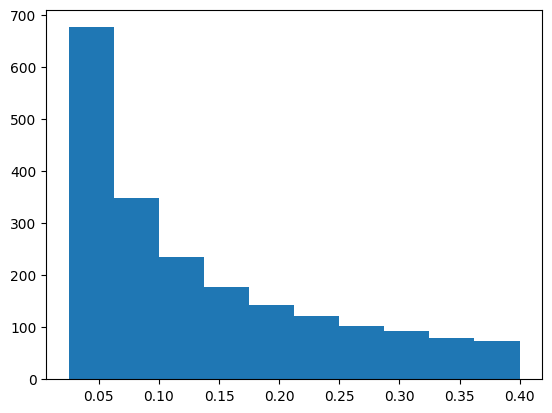

In [5]:
# plot the first one (omega0) to see shape of prior:
plt.hist(theta[:, 24])

In [6]:
def calc_df(_x, volume, massBinLimits):
    hist, _dummy = np.histogram(_x, bins=massBinLimits)
    hist = np.float64(hist)
    phi = (hist / volume) / (massBinLimits[1] - massBinLimits[0])

    phi_sigma = (np.sqrt(hist) / volume) / (
        massBinLimits[1] - massBinLimits[0]
    )  # Poisson errors

    return phi, phi_sigma, hist

def get_luminosity_function(
    photo,
    filt,
    lo_lim,
    hi_lim,
    n_bins=15,
    mask=None,
):
    h = 0.6711
    if mask is None:
        mask = np.ones(len(photo[filt]), dtype=bool)

    binLimits = np.linspace(lo_lim, hi_lim, n_bins)
    phi, phi_sigma, hist = calc_df(photo[filt][mask], (25 / h) ** 3, binLimits)
    phi[phi == 0.0] = 1e-6 + np.random.rand() * 1e-7
    phi = np.log10(phi)
    return phi, phi_sigma, hist, binLimits

def get_photometry_SB(
    sim_name="SB28_0",
    spec_type="attenuated",
    snap="044",
    sps="BC03",
    model="IllustrisTNG",
    photo_dir="/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/photometry",
    filters=["GALEX FUV", "GALEX NUV"],
):
    photo = {}
    with h5py.File(f"{photo_dir}/alice_galex.h5", "r") as hf:
        for filt in filters:
            path = f"{sim_name}/snap_{snap}/{sps}/photometry/luminosity/{spec_type}/{filt}"
            photo[filt] = hf[path][:]
            # Note: Assuming data is already in desired format, remove conversion if not needed
            # photo[filt] *= unyt_quantity.from_string("1 erg/s/Hz")
            # photo[filt] = lnu_to_absolute_mag(photo[filt])
    return photo

def get_theta_SB(model="IllustrisTNG", device="cuda"):
    cam = camels(model=model, sim_set='SB28')
    theta = np.array([
        cam.params['Omega0'].values,              # Omega0
        cam.params['sigma8'].values,              # sigma8
        cam.params['WindEnergyIn1e51erg'].values, # Wind Energy in 1e51 erg
        cam.params['RadioFeedbackFactor'].values,  # Radio Feedback Factor
        cam.params['VariableWindVelFactor'].values, # Variable Wind Velocity Factor
        cam.params['RadioFeedbackReiorientationFactor'].values, # Radio Feedback Reorientation Factor
        cam.params['OmegaBaryon'].values,         # Omega Baryon
        cam.params['HubbleParam'].values,         # Hubble Parameter
        cam.params['n_s'].values,                 # n_s
        cam.params['MaxSfrTimescale'].values,     # Max SFR Timescale
        cam.params['FactorForSofterEQS'].values,  # Factor for Softer EQS
        cam.params['IMFslope'].values,            # IMF slope
        cam.params['SNII_MinMass_Msun'].values,   # SNII Minimum Mass (Msun)
        cam.params['ThermalWindFraction'].values, # Thermal Wind Fraction
        cam.params['VariableWindSpecMomentum'].values, # Variable Wind Specific Momentum
        cam.params['WindFreeTravelDensFac'].values, # Wind Free Travel Density Factor
        cam.params['MinWindVel'].values,          # Minimum Wind Velocity
        cam.params['WindEnergyReductionFactor'].values, # Wind Energy Reduction Factor
        cam.params['WindEnergyReductionMetallicity'].values, # Wind Energy Reduction Metallicity
        cam.params['WindEnergyReductionExponent'].values, # Wind Energy Reduction Exponent
        cam.params['WindDumpFactor'].values,      # Wind Dump Factor
        cam.params['SeedBlackHoleMass'].values,   # Seed Black Hole Mass
        cam.params['BlackHoleAccretionFactor'].values, # Black Hole Accretion Factor
        cam.params['BlackHoleEddingtonFactor'].values, # Black Hole Eddington Factor
        cam.params['BlackHoleFeedbackFactor'].values, # Black Hole Feedback Factor
        cam.params['BlackHoleRadiativeEfficiency'].values, # Black Hole Radiative Efficiency
        cam.params['QuasarThreshold'].values,     # Quasar Threshold
        cam.params['QuasarThresholdPower'].values # Quasar Threshold Power
    ]).T
    
    return torch.tensor(theta, dtype=torch.float32, device=device)
    

def get_x_SB(
    spec_type="attenuated",
    snap="044",
    sps="BC03",
    luminosity_functions=True,
    colours=True,
    model="IllustrisTNG",
    photo_dir="/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/photometry",
    n_bins_lf=13,
    n_bins_colour=13,
):
    if isinstance(snap, str):
        snap = [snap]

    x = [[] for _ in range(2048)]  # For SB28 simulations

    for SB28_ in range(2048):
        try:
            for snp in snap:
                photo = get_photometry_SB(
                    sim_name=f"SB28_{SB28_}",
                    spec_type=spec_type,
                    snap=snp,
                    sps=sps,
                    model=model,
                    photo_dir=photo_dir,
                )

                if luminosity_functions:
                    for filt, lo_lim, hi_lim in zip(
                        ["GALEX FUV", "GALEX NUV"],
                        [-20.5, -20.5],
                        [-15, -15],
                    ):
                        phi = get_luminosity_function(
                            photo, filt, lo_lim, hi_lim, n_bins=n_bins_lf
                        )[0]
                        x[SB28_].append(phi)

                if colours:
                    binLimsColour = np.linspace(-0.5, 3.5, n_bins_colour)
                    color = photo["GALEX FUV"] - photo["GALEX NUV"]
                    color_dist = np.histogram(color, binLimsColour, density=True)[0]
                    x[SB28_].append(color_dist)
        except Exception as e:
            print(f"Error processing simulation {SB28_}: {e}")
            x[SB28_] = None

    # Remove any failed simulations
    x = [xi for xi in x if xi is not None]
    
    return x


def get_theta_x_SB(
    spec_type="attenuated",
    snap="044",
    sps="BC03",
    model="IllustrisTNG",
    device="cuda",
    **kwargs,
):
    x = get_x_SB(spec_type=spec_type, snap=snap, sps=sps, model=model, **kwargs)
    theta = get_theta_SB(model=model, device=device)
    
    # Convert x list to proper array format
    x_array = np.array([np.hstack(_x) for _x in x])
    return theta, x_array


if __name__ == "__main__":
    theta, x = get_theta_x_SB()
    print(theta.shape, x.shape)


/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


torch.Size([2048, 28]) (2048, 36)


In [7]:

# get the priors and data
prior = initialise_priors_SB28(df=df_info, device=device)
theta, x = get_theta_x_SB(
    spec_type=spec_type,
    snap=snap,
    sps=sps,
    model=model,
    device=device,
    n_bins_lf=n_bins_lf,
    n_bins_colour=n_bins_colour,
    photo_dir="/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/photometry"
)

# process the data
x_all = np.array([np.hstack(_x) for _x in x])
x_all = torch.tensor(x_all, dtype=torch.float32, device=device)

print("Theta shape:", theta.shape)
print("X shape:", x_all.shape)

processing Omega0:
processing Omega0 is linear with min 0.1 and max 0.5:
processing sigma8:
processing sigma8 is linear with min 0.6 and max 1.0:
processing WindEnergyIn1e51erg:
processing WindEnergyIn1e51erg is logarithmic with min 0.9 and max 14.4:
processing RadioFeedbackFactor:
processing RadioFeedbackFactor is logarithmic with min 0.25 and max 4.0:
processing VariableWindVelFactor:
processing VariableWindVelFactor is logarithmic with min 3.7 and max 14.8:
processing RadioFeedbackReiorientationFactor:
processing RadioFeedbackReiorientationFactor is logarithmic with min 10.0 and max 40.0:
processing OmegaBaryon:
processing OmegaBaryon is linear with min 0.029 and max 0.069:
processing HubbleParam:
processing HubbleParam is linear with min 0.4711 and max 0.8711:
processing n_s:
processing n_s is linear with min 0.7624 and max 1.1624:
processing MaxSfrTimescale:
processing MaxSfrTimescale is logarithmic with min 1.135 and max 4.54:
processing FactorForSofterEQS:
processing FactorForSo

/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/user_input_checks.py:76: UserWarning: Prior was provided as a sequence of 32 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/user_input_checks.py:209: UserWarning: Casting 1D Uniform prior to BoxUniform to match sbi batch requirements.
  warnings.warn(
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/numpy/lib/histogram

Theta shape: torch.Size([2048, 28])
X shape: torch.Size([2048, 33])


In [8]:

def create_test_mask(n_sims=2048, test_fraction=0.1, random_seed=42):
    """
    Create a test mask similar to the LH one but for 2048 simulations.
    
    Args:
        n_sims: Number of simulations (2048 for SB28)
        test_fraction: Fraction of simulations to use for testing (0.1 = 10%)
        random_seed: Random seed for reproducibility
    
    Returns:
        np.array: Boolean mask where True indicates test set
    """
    np.random.seed(random_seed)
    test_mask = np.random.rand(n_sims) > (1 - test_fraction)
    
    # Print some statistics
    print(f"Total simulations: {n_sims}")
    print(f"Test set size: {test_mask.sum()}")
    print(f"Training set size: {(~test_mask).sum()}")
    print(f"Test fraction: {test_mask.sum() / n_sims:.3f}")
    
    # Save the mask
    save_path = "/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/test/test_mask_SB28.txt"
    np.savetxt(save_path, test_mask.astype(int), fmt='%i')
    
    return test_mask


In [9]:

# Move data to GPU as early as possible
x_all = x_all.to(device)
x_all


tensor([[-5.9746, -5.9746, -5.9746,  ...,     nan,     nan,     nan],
        [-5.9895, -5.9895, -5.9895,  ...,     nan,     nan,     nan],
        [-5.9766, -5.9766, -5.9766,  ...,     nan,     nan,     nan],
        ...,
        [-5.9617, -5.9617, -5.9617,  ...,     nan,     nan,     nan],
        [-5.9832, -5.9832, -5.9832,  ...,     nan,     nan,     nan],
        [-5.9768, -5.9768, -5.9768,  ...,     nan,     nan,     nan]],
       device='cuda:0')

In [10]:
theta = torch.tensor(theta, dtype=torch.float32, device=device)
theta

/tmp/ipykernel_2882910/964306182.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32, device=device)


tensor([[3.5254e-01, 6.9474e-01, 3.8574e+00,  ..., 2.2539e-01, 2.6936e-04,
         5.1465e-01],
        [1.7243e-01, 8.3015e-01, 1.0355e+00,  ..., 8.6231e-02, 2.2802e-02,
         2.6208e+00],
        [2.3468e-01, 7.0584e-01, 9.6142e+00,  ..., 6.4810e-01, 1.4576e-03,
         3.3896e+00],
        ...,
        [2.3448e-01, 9.3876e-01, 1.4972e+00,  ..., 6.8262e-01, 6.2632e-03,
         3.1172e+00],
        [1.7261e-01, 6.1289e-01, 1.3312e+01,  ..., 8.3655e-02, 7.0985e-05,
         2.8879e+00],
        [3.5236e-01, 8.6222e-01, 3.0993e+00,  ..., 2.5622e-01, 3.6493e-02,
         9.9407e-01]], device='cuda:0')

In [11]:

# Handle NaN values and normalize while on GPU
x_all_cpu = x_all.cpu().numpy()  # Only move to CPU when necessary for sklearn
x_all_cpu


array([[-5.9746146, -5.9746146, -5.9746146, ...,        nan,        nan,
               nan],
       [-5.9895086, -5.9895086, -5.9895086, ...,        nan,        nan,
               nan],
       [-5.9765553, -5.9765553, -5.9765553, ...,        nan,        nan,
               nan],
       ...,
       [-5.961686 , -5.961686 , -5.961686 , ...,        nan,        nan,
               nan],
       [-5.983155 , -5.983155 , -5.983155 , ...,        nan,        nan,
               nan],
       [-5.9768047, -5.9768047, -5.9768047, ...,        nan,        nan,
               nan]], dtype=float32)

In [12]:
print("Data shape before processing:", x_all_cpu.shape)
print("Number of NaN values:", np.isnan(x_all_cpu).sum())
print("Number of infinite values:", np.isinf(x_all_cpu).sum())


Data shape before processing: (2048, 33)
Number of NaN values: 22528
Number of infinite values: 0


In [13]:

# Replace NaN/inf values with small random noise
nan_mask = np.isnan(x_all_cpu) | np.isinf(x_all_cpu)
nan_mask



array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [14]:

if nan_mask.any():
    x_all_cpu[nan_mask] = np.random.rand(np.sum(nan_mask)) * 1e-10


In [15]:
x_all_cpu

array([[-5.9746146e+00, -5.9746146e+00, -5.9746146e+00, ...,
         2.8474277e-11,  4.1219680e-11,  3.4359290e-11],
       [-5.9895086e+00, -5.9895086e+00, -5.9895086e+00, ...,
         7.7192724e-11,  1.2184925e-13,  6.9775519e-11],
       [-5.9765553e+00, -5.9765553e+00, -5.9765553e+00, ...,
         6.1756857e-11,  2.6599755e-11,  7.6820550e-11],
       ...,
       [-5.9616861e+00, -5.9616861e+00, -5.9616861e+00, ...,
         9.6711224e-12,  5.0778375e-11,  9.8895295e-11],
       [-5.9831548e+00, -5.9831548e+00, -5.9831548e+00, ...,
         2.0021346e-11,  1.4750040e-11,  2.4220289e-11],
       [-5.9768047e+00, -5.9768047e+00, -5.9768047e+00, ...,
         7.2613894e-11,  4.3789149e-11,  6.2824641e-11]], dtype=float32)

In [16]:
print("Data shape before processing:", x_all_cpu.shape)
print("Number of NaN values:", np.isnan(x_all_cpu).sum())
print("Number of infinite values:", np.isinf(x_all_cpu).sum())


Data shape before processing: (2048, 33)
Number of NaN values: 0
Number of infinite values: 0


In [17]:

# Normalize
norm = Normalizer()
x_all_normalized = norm.fit_transform(x_all_cpu)
x_all = torch.tensor(x_all_normalized, dtype=torch.float32, device=device)
x_all

tensor([[-2.1297e-01, -2.1297e-01, -2.1297e-01,  ...,  1.0150e-12,
          1.4693e-12,  1.2247e-12],
        [-2.1304e-01, -2.1304e-01, -2.1304e-01,  ...,  2.7457e-12,
          4.3340e-15,  2.4818e-12],
        [-2.1343e-01, -2.1343e-01, -2.1343e-01,  ...,  2.2054e-12,
          9.4991e-13,  2.7434e-12],
        ...,
        [-2.1320e-01, -2.1320e-01, -2.1320e-01,  ...,  3.4586e-13,
          1.8159e-12,  3.5367e-12],
        [-2.1292e-01, -2.1292e-01, -2.1292e-01,  ...,  7.1247e-13,
          5.2489e-13,  8.6190e-13],
        [-2.1284e-01, -2.1284e-01, -2.1284e-01,  ...,  2.5858e-12,
          1.5594e-12,  2.2372e-12]], device='cuda:0')

In [18]:

# Save normalizer
joblib.dump(norm, f'/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/{name}_scaler.save')

# Print final check
print("Any NaN in normalized data:", torch.isnan(x_all).any().item())
print("Any inf in normalized data:", torch.isinf(x_all).any().item())


Any NaN in normalized data: False
Any inf in normalized data: False


In [19]:


# Load test mask
test_mask = create_test_mask()
test_mask


Total simulations: 2048
Test set size: 203
Training set size: 1845
Test fraction: 0.099


array([False,  True, False, ..., False, False, False])

# original

hidden_features = 30
num_transforms = 4
nets = [
    # ili.utils.load_nde_sbi(
    #     engine="NLE", model="maf", hidden_features=50, num_transforms=5
    # ),
    ili.utils.load_nde_sbi(
        engine="NPE",
        model="nsf", hidden_features=hidden_features, num_transforms=num_transforms
    ),
    '''

    ili.utils.load_nde_sbi(
        engine="NPE",
        model="nsf", hidden_features=hidden_features, num_transforms=num_transforms
    ),
    ili.utils.load_nde_sbi(
        engine="NPE",
        model="nsf", hidden_features=hidden_features, num_transforms=num_transforms
    ),
    # ili.utils.load_nde_sbi(
    #     engine="NPE",
    #     model="nsf", hidden_features=hidden_features, num_transforms=num_transforms
    # ),
    # ili.utils.load_nde_lampe(model="nsf", device=device, hidden_features=20, num_transforms=2), 
    # ili.utils.load_nde_lampe(model="nsf", device=device, hidden_features=20, num_transforms=2), 
    '''
]
print(nets)


train_args = {"training_batch_size": 4, "learning_rate": 5e-4, 'stop_after_epochs': 20}
print(train_args)


loader = NumpyLoader(
    x=x_all[~test_mask],
    # theta=torch.tensor(theta[~test_mask], device=device)
    theta=torch.tensor(theta[~test_mask, :], device=device)
)
print(loader)

runner = InferenceRunner.load(
    backend="sbi",  #'sbi', # 'lampe',
    engine="NPE",
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    # embedding_net=None,
    out_dir="models/",
    name=name,
)
print(runner)

posterior_ensemble, summaries = runner(loader=loader)
print(posterior_ensemble)

In [ ]:
# Configure network properly
hidden_features = 30
num_transforms = 4
net = ili.utils.load_nde_sbi(
    engine="NPE",
    model="nsf",
    hidden_features=hidden_features,
    num_transforms=num_transforms,
    # Remove device parameter as it's not allowed
)

# Training arguments
train_args = {
    "training_batch_size": 128,
    "learning_rate": 1e-3,
    "stop_after_epochs": 20
}

# Data loader
loader = NumpyLoader(
    x=x_all[~test_mask].clone().detach(),
    theta=theta[~test_mask].clone().detach()
)

# Runner setup with device specified here
runner = InferenceRunner.load(
    backend="sbi",
    engine="NPE",
    prior=prior,
    nets=[net],
    device=device,  # Device specified in runner, not network
    train_args=train_args,
    proposal=None,
    out_dir="/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/",
    name=name
)

# Run training
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE


/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 1.


 Training neural network. Epochs trained: 2

In [ ]:
summaries

In [ ]:
"""
Coverage plots for each model
"""
metric = PosteriorCoverage(
    num_samples=int(4e3),
    sample_method='direct',
    # sample_method="slice_np_vectorized",
    # sample_params={'num_chains': 1},
    # sample_method="vi",
    # sample_params={"dist": "maf", "n_particles": 32, "learning_rate": 1e-2},
    labels=cam.labels,
    plot_list=["coverage", "histogram", "predictions", "tarp"],
    out_dir="../plots/",
)
metric

In [ ]:

fig = metric(
    posterior=posterior_ensemble,
    x=x_all[test_mask].cpu(),
    # theta=theta[test_mask].cpu(),
    theta=theta[test_mask, :].cpu(),
    signature=f"coverage_{name}_",
)